# Home assignment 3 (17 pts) 

## Only filled ipynb file should be submitted in Stepik!

## Problem 1. Control by landing of spaceship (10 pts)

Practical implementation of the ideas from this problem see [here](https://www.youtube.com/watch?v=2t15vP1PyoA)

In this problem we assume that the dynamic of spaceship controls by the Newton's second law

$$
mx''(t) = f(t) - mge_3,
$$

where $e_3$ is a vector $(0, 0, 1)$, $m$ is a mass that is constant by our assumption (otherwise we will get much complicated dynamic), $f(t)$ is a force that we can control, $x''(t)$ is acceleration.
We also skip the atmosphere affects.
This is vector equation, so $x(t)$ and $f(t)$ and 3D vectors in every timestamp. 

#### Dynamic equation we can get after discretization of the above equation

For speed we get

$$
m\frac{v_{k+1} - v_k}{h} = f_k - mge_3, \quad v_{k+1} = v_k + \frac{h}{m} f_k - hge_3
$$

and similarly for coordinates

$$
x' = v \quad x_{k+1} = x_k + \frac{h}{2}(v_k + v_{k+1})
$$

We use here Runge-Kutta method of the order 2, more details see [here](http://web.mit.edu/10.001/Web/Course_Notes/Differential_Equations_Notes/node5.html).

The landing point has coordinates $(0, 0, 0)$ and for successful landing the final speed has to be zero. 
Also, during the landing it is important to prevent shift of the spaceshift in the vertical axis, so the $z$-coordinate can not be smaller than its projection on the plane $(x, y)$ in given factor

$$
x_3(t) \geq \alpha \| (x_1(t), x_2(t)) \|_2.
$$

Since force is created my engine that consumes fuel, we have some upper bound on the force

$$
\|f(t)\|_2 \leq F_{\max}.
$$

Also the amount of the consumed fuel can be computed by the following equation

$$
\gamma \int_0^T \|f(t)\|_2 dt,
$$

 where $\gamma$ is a fuel consumption coefficient, $T$ is a landing time. 
 
During time discretization we can assume that $f(t)$ is constant in every interval $[(k-1)h; kh]$ for $k=1,\ldots,K$. Thus, the total time for landing is $Kh$. 

**Task 1**
Find the position, speed and forse in evert timestamp such that the total amount of consumed fuel is minimal

1) (2 pts) State optimization problem formally. It means define the objective function, variables and constraints explicitly in mathematical way.

2) (3 pts) Solve it with CVXPy and visualize solution 

**Task 2**
Find the minimal time that is sufficient to land the spaceship. i.e. if the time discretization step $h$ is fixed, we need to find the minimal time to move spaceship from the initial point to the final point with final speed.
You can solve multiple auxilliary problem to solve this problem.

3) (5 pts) State optimization problem formally and simplify as much as possible

4) (4 pts) Solve it with CVXPy and visualize solution. Compare the resulted trajectory with the trajectory from the task 1. How much requirement of the minimal time increased the amount of consumed fuel?

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import cvxpy as cvx
import math

# Time discretiztion step
h = 1.
# Gravity acceleration. It is just demo value to scale the solution time!
g = 0.1
# Mass
m = 10.
# Maximum norm of forse
Fmax = 10.
# Initial position
p0 = np.array([50, 50, 100])
# Initial velocity
v0 = np.array([-10, 0, -10])
# Factor of minimum slope
alpha = 0.5
# Fuel consumption factor
gamma = 1.
# Number of discretization steps, i.e. final time equals K*h
K = 35

In [2]:
# Your solution is here
### [SOLUTION] ###

# Task 1 
# Find the position, speed and forse in evert timestamp such that the total 
# amount of consumed fuel is minimal

e3 = np.array([0,0,1])

# 1) State optimization problem formally. It means define the objective 
# function, variables and constraints explicitly in mathematical way.

f = cvx.Variable((3, K))
p = cvx.Variable((3, K))
v = cvx.Variable((3, K))

constraints = list()
constraints += [p[2,k] >= alpha * cvx.norm2(p[:2,k]) for k in range(K)]
constraints += [cvx.norm2(f[:,k]) <= Fmax for k in range(K)]
constraints += [v[:,k+1] == v[:,k] + h / m * f[:,k] - h * g * e3 for k in range(K-1)]
constraints += [p[:,k+1] == p[:,k] + h / 2 * (v[:,k] + v[:,k+1]) for k in range(K-1)]
constraints += [p[:,0] == p0]
constraints += [p[:,-1] == np.array([0, 0, 0])]
constraints += [v[:,0] == v0]
constraints += [v[:,-1] == np.array([0, 0, 0])]

fuel = [gamma * h * cvx.norm2(f[:, k]) for k in range(K)]
obj = cvx.Minimize(cvx.sum(fuel))

# 2) Solve it with CVXPy and visualize solution

prob = cvx.Problem(obj, constraints)
optimal_fuel = prob.solve(verbose=True)

px = p.value[0,:]
py = p.value[1,:]
pz = p.value[2,:]

### [SOLUTION] ###

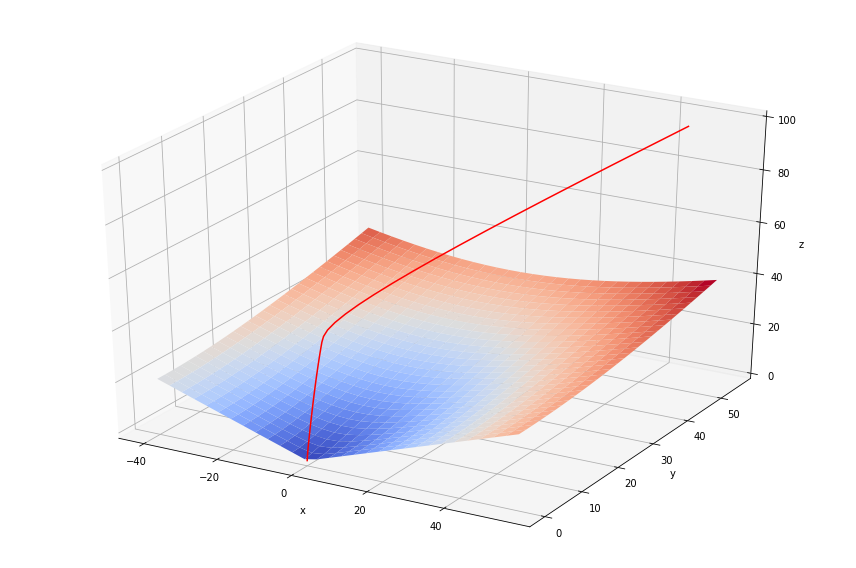

In [3]:
# use the following code to plot your trajectories
# and the glide cone
# -------------------------------------------------------
fig = plt.figure(figsize=(12, 8))
ax = fig.gca(projection='3d')

X = np.linspace(-40, 55, num=30)
Y = np.linspace(0, 55, num=30)
X, Y = np.meshgrid(X, Y)
Z = alpha*np.sqrt(X**2+Y**2)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.plot(xs=px,ys=py,zs=pz, c="red",zorder=10)

ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.tight_layout()

In [41]:
### [SOLUTION] ###

# Task 2 Find the minimal time that is sufficient to land the spaceship. 
# i.e. if the time discretization step  h is fixed, we need to find the minimal 
# time to move spaceship from the initial point to the final point with final 
# speed. You can solve multiple auxilliary problem to solve this problem.

# 3) State optimization problem formally and simplify as much as possible

def optimize(K):
    f = cvx.Variable((3, K))
    p = cvx.Variable((3, K))
    v = cvx.Variable((3, K))

    constraints = list()
    constraints += [p[2,k] >= alpha * cvx.norm2(p[:2,k]) for k in range(K)]
    constraints += [cvx.norm2(f[:,k]) <= Fmax for k in range(K)]
    constraints += [v[:,k+1] == v[:,k] + h / m * f[:,k] - h * g * e3 for k in range(K-1)]
    constraints += [p[:,k+1] == p[:,k] + h / 2 * (v[:,k] + v[:,k+1]) for k in range(K-1)]
    constraints += [p[:,0] == p0]
    constraints += [p[:,-1] == np.array([0, 0, 0])]
    constraints += [v[:,0] == v0]
    constraints += [v[:,-1] == np.array([0, 0, 0])]

    fuel = [gamma * h * cvx.norm2(f[:, k]) for k in range(K)]
    obj = cvx.Minimize(cvx.sum(fuel))

    prob = cvx.Problem(obj, constraints)
    min_fuel = prob.solve(verbose=False)

    return f, p, v, min_fuel

# 4) Solve it with CVXPy and visualize solution. Compare the resulted 
# trajectory with the trajectory from the task 1. How much requirement of the 
# minimal time increased the amount of consumed fuel?

is_min = False
K_mint = K
fuel_mint = optimal_fuel
print(f"The number of discretization steps; Fuel")
for i in range(20,40):
    f, p, v, min_fuel = optimize(i)
    if not is_min and min_fuel < math.inf:
        is_min = True
        p_mint = p
        K_mint = i
        fuel_mint = min_fuel
        print(f"{i}; {min_fuel} <--- MIN time")
    print(f"{i}; {min_fuel}")

print(f"""
How much requirement of the minimal time increased the amount of consumed fuel?
Steps difference: {K_mint-K}
Fuel difference: {fuel_mint-optimal_fuel}
""")

### [SOLUTION] ###

The number of discretization steps; Fuel
20; inf
21; inf
22; inf
23; inf
24; inf
25; inf
26; 245.63029260815824 <--- MIN time
26; 245.63029260815824
27; 222.41350047175519
28; 212.49539243734165
29; 206.60313834667318
30; 202.58561636779348
31; 199.62947437662964
32; 197.49387762751564
33; 195.8842914127343
34; 194.6422049123744
35; 193.68880645622824
36; 192.9912253410494
37; 192.47323422548138
38; 192.10486972198453
39; 191.86323349589412

How much requirement of the minimal time increased the amount of consumed fuel?
Steps difference: -9
Fuel difference: 51.94148615193001



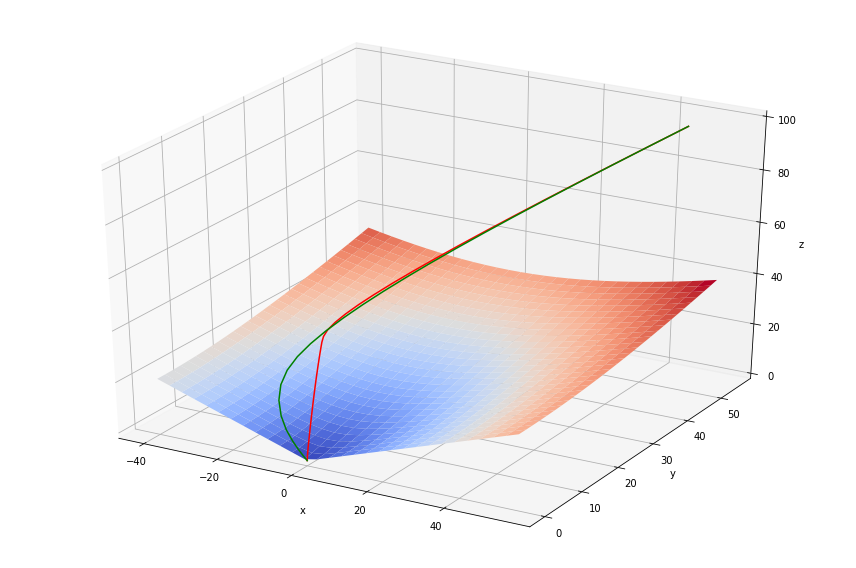

In [5]:
# use the following code to plot your trajectories
# and the glide cone
# -------------------------------------------------------
fig = plt.figure(figsize=(12, 8))
ax = fig.gca(projection='3d')

X = np.linspace(-40, 55, num=30)
Y = np.linspace(0, 55, num=30)
X, Y = np.meshgrid(X, Y)
Z = alpha*np.sqrt(X**2+Y**2)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.plot(xs=px,ys=py,zs=pz, c="red",zorder=10)
ax.plot(xs=p_mint.value[0,:],ys=p_mint.value[1,:],zs=p_mint.value[2,:], c="green",zorder=15)

ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.tight_layout()

## Problem 2. Nonnegative matrix factorization (7 pts) 

__1.__ Download the the code below a dataset with photos and plot any of the samples.

In [1]:
!pip install scs==2.1.4

In [42]:
import sklearn.datasets as skldata
import matplotlib.pyplot as plt
import sklearn.decomposition as skdec
%matplotlib inline
data = skldata.fetch_olivetti_faces()
import numpy as np

Shape of data = (400, 64, 64)


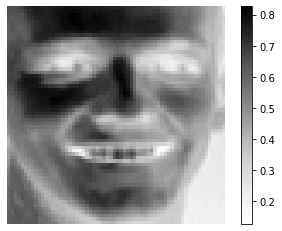

In [43]:
print("Shape of data = {}".format(data["images"].shape))
index = 42
plt.imshow(data["images"][index], cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

__2.__ One of the classical approach to image and in general signal processing is [nonnegative matrix factorization](https://arxiv.org/pdf/1401.5226.pdf)). 
Idea of the method is to solve the following optimization problem

\begin{align*}
& \min_{W, H} \frac12 \|X - WH\|^2_F \\
\text{s.t. } & W \geq 0\\
& H \geq 0,
\end{align*}

where symbol $\geq$ denotes elementwise comparison. 
Also matrices $W$ and $H$ are lowrank, i.e. $W \in \mathbb{R}^{m \times k}$ and $H \in \mathbb{R}^{k \times n}$, where $k$ is a hyper-parameter that has to be tuned.
The larger $k$, the more accurate approximation, but more time is needed to solve the problem.
The matrix $X \in \mathbb{R}^{m \times n}$, where $m$ is a number of photos in our dataset, and $n$ is a umber of pixels in every picture, i.e. every row of the matrix $X$ is a vectorized image.

**Tasks**

1) (1 pts) is the above problem convex and why?

2) (1 pts) how can you interpret factors $W$ and $H$ and why its nonnegativity is important?

\# Cell for your answer

\### [SOLUTION] ###

1) is the above problem convex and why?

Let's consider the partial case to simplify calculations and generalize the conclusion to a higher dimensiona, e.g. the following:

$$W \in R,\ H \in R $$

$$ \min_{W, H} \frac12 (X - WH)^2 = \min_{W, H} \frac12 (X^2 - 2WHX + W^2H^2) $$

The gradient is:

$$ \nabla f(H,W)=\begin{pmatrix}
-2HX+2WH^2 \\ -2WX+2W^2H
\end{pmatrix} $$

The Hessian is:

$$ \nabla^2 f(H,W)=\begin{pmatrix}
2H^2 & -2X+4WH \\
-2X+4WH & 2W^2
\end{pmatrix}$$

According to the Sylvester's criterion, the Hession is not PSD, thus, the problem is not convex.

2) how can you interpret factors  W  and  H  and why its nonnegativity is 
important?

- How can you interpret factors  W  and  H?

I suppose that H is a feature matrix of our images. And W is the "weight" matrix which shows how much this feature is expressed for each of the images.

- Why its nonnegativity is important?

Because we cannot have negative color (it's 0 to 1 by condition). And also we cannot have a negative expression of a feature for each image.

\### [SOLUTION] ###

__3.__ This problem can be approximately solved with CVXPy if the alternating optimization is used. The idea of this method is in even iterations solve the problem w.r.t $W$ while the matrix $H$ is fixed and in the odd iterations use optimal value of $W$ from the previous iteration as a fixed matrix and solve the problem w.r.t. $H$. And keep such alternating until convergence w.r.t. the changing the objective function.
Before run this method you need to initialize matrices $W$ and $H$ with some non-negative elements, probably random. The quality of the solution and running time of the method crucially depend on the initialization. So, you can test different approaches and report result of your investigation additionally.

**Tasks**

1) (2 pts) implement with CVXPy the alternating optimization method for this problem and solve it for some reasonable fixed $k$

2) (1 pts) plot the convergence line (objective function value vs. iteration idx) and confirm that the method converegs or the changing in objective function with iterating is very small

3) (1 pts) since the dimension of matrix $H$ is $k \times n$, then every row of $H$ can be transformed to photo in the inverse manner like they were collected in rows of matrix $X$. Plot 10-50 pictures extracted from rows of matrix $H$. What do you observe and how your observation relates to your answer the question 2) in the previous block of tasks? Use ```plt.colorbar()``` and colour scheme ```plt.cm.Greys``` for more constrast displaying the pixels

4) (1 pts) Plot matrix $W$ with functions ```plt.imshow``` or ```plt.spy``` from the ```matplotlib``` library. How much sparse is it?

In [44]:
X_init = np.array([data["images"][i].flatten() for i in range(400)])

In [45]:
X_init.shape

(400, 4096)

In [ ]:
# Cell for your code
### [SOLUTION] ###
# 1) (2 pts) implement with CVXPy the alternating optimization method for this 
# problem and solve it for some reasonable fixed  k 

m = 12
n = 4096

def optimize(k, m=400, n=4096, steps=10):
    X = X_init[:m, :n]
    W_fixed = np.random.rand(m, k)
    H_fixed = np.random.rand(n, k)
    min_err_res = list()
    for i in range(steps):
        if i % 2 == 0:
            W = cvx.Variable((m, k))
            constraints = [W[:,:] >= 0]
            if i > 1:
                H_fixed = H.value
            err = X - W @ H_fixed.T
        else:
            H = cvx.Variable((n, k))
            constraints = [H[:,:] >= 0]
            if i > 1:
                W_fixed = W.value
            err = X - W_fixed @ H.T

        obj = cvx.Minimize(1/2*(cvx.norm(err)**2))

        prob = cvx.Problem(obj, constraints)
        min_err = prob.solve(solver=cvx.SCS, max_iters=1000, verbose=False)
        min_err_res.append(min_err)
        print(f'Step {i}. Min error is: {min_err}')

    return min_err_res, H.value, W.value


min_err_res, H_res, W_res = optimize(10, m=m, n=n, steps=8)

In [ ]:
# 2) (1 pts) plot the convergence line (objective function value vs. iteration 
# idx) and confirm that the method converegs or the changing in objective 
# function with iterating is very small

plt.title("Convergence line")
plt.xlabel("iteration")
plt.ylabel("Error")
plt.plot(range(len(min_err_res)), min_err_res, color ="red")
plt.show()

In [ ]:
H_res.shape

In [ ]:
# 3) (1 pts) since the dimension of matrix  H  is  k×n , then every row of  H 
#  can be transformed to photo in the inverse manner like they were collected
#  in rows of matrix  X . Plot 10-50 pictures extracted from rows of matrix  H .

plt.imshow(np.reshape(H_res.T[0], (16,64)), cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

In [ ]:
plt.imshow(np.reshape(H_res.T[1], (16,64)), cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

In [ ]:
plt.imshow(np.reshape(H_res.T[2], (16,64)), cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

In [ ]:
#  What do you observe and how your observation relates to your answer the 
# question 2) in the previous block of tasks? Use plt.colorbar() and colour 
# scheme plt.cm.Greys for more constrast displaying the pixels

# [ANSWER]
# We can see the different features of the human faces. 
# As it was assumed in p.2.

In [ ]:
# 4) (1 pts) Plot matrix  W  with functions plt.imshow or plt.spy from the 
# matplotlib library. How much sparse is it?

plt.imshow(W_res, cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

In [ ]:
# Well, sparse enough. If we used some larger variables, 
# we would experience a higher power of sparcity of different features
# being expressed for different faces.